<a href="https://colab.research.google.com/github/mh-sarkar/singleBaseDeepDNA/blob/main/DeepDNA_05_06_2022_for_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connecting Google Drive

---


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Library

---



In [ ]:
!pip install Bio
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 270 kB 5.3 MB/s 
     |████████████████████████████████| 2.3 MB 68.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
import numpy as np
import sys
import io
import math
import tensorflow as tf
import keras

from __future__ import print_function
from itertools import product

from Bio import SeqIO
from Bio.Seq import Seq
# from Bio.Alphabet import generic_dna

from keras import backend as K
from keras.callbacks import LambdaCallback, Callback
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.utils.data_utils import get_file
from keras.models import model_from_json
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import RMSprop

#Define Constant

---



In [ ]:
SEQ_MAX_LEN = 16400
CHARS = "ACGT"
# print('total chars:', len(CHARS))
# print('chars:', CHARS)
CHAR_INDICES = dict((c, i) for i, c in enumerate(CHARS))
INDICES_CHAR = dict((i, c) for i, c in enumerate(CHARS))
MAXLEN = 64
STEP = 1
BATCH_SIZE = 4096
INITIAL_LR = 0.001
GLOBAL_DECAY_STEPS = 10000
GLOBAL_DECAY_RATE = 0.9
EPOCHS = 10
INPUT_DIM = len(CHARS)

# **Data Split** ▶▶

---



##Read Full Mitocondrial DNA

In [ ]:
filename ='MYTROONDRIA_DNA_FASTA_FILE_PATH'# downloaded multi-fasta file from MITOMAP database
reads = []
with open(filename, "r") as handle:
	for record in SeqIO.parse(handle, "fasta") :
		if(len(record.seq) > SEQ_MAX_LEN):
			reads.append(record)
# print(len(reads))

##Create ACGT Map for Consensus

In [ ]:
my_map_data = {'A':0, 'C':1, 'G':2, 'T':3}

In [ ]:
def get_key(val):
    for key, value in my_map_data.items():
         if val == value:
             return key
 
    return ""

##Consensus Sequence

In [ ]:
twod_list = []
a=[]
t=[]
g=[]
c=[]
for j in range(len(max(reads, key=len))):
    a.append([i[j] for i in reads if j< len(i)].count('A'))
    t.append([i[j] for i in reads if j< len(i)].count('T'))
    g.append([i[j] for i in reads if j< len(i)].count('G'))
    c.append([i[j] for i in reads if j< len(i)].count('C'))

twod_list.append(a)
twod_list.append(c)
twod_list.append(g)
twod_list.append(t)
A = np.asarray(twod_list)

max = A.max(axis=0, keepdims=True)
max_index = A.argmax(axis=0)

## Main Sequence Data Split

In [ ]:
items = range(len(reads))
# random.shuffle(items)

train, test = train_test_split(items, test_size=0.10, random_state=42)
train, valid = train_test_split(train,test_size=0.18, random_state=42) # 0.25 x 0.8 = 0.2

# train = items[0:1407]
# valid = items[1407:1809]
# test = items[1809:2011]
train_record = []
valid_record = []
test_record = []

##Apply Consensus ▶

---



###Check and Apply Consensus Function

In [ ]:
def check(read):
	record = read
	my_dna = str(read.seq.upper())
	for i, base in enumerate(my_dna):
		if base not in 'ACGT':
			# print(base, get_key(max_index[i]))
			my_dna = my_dna.replace(base,get_key(max_index[i]))
	record.seq= Seq(my_dna)
	for i, base in enumerate(record.seq):
		if base not in 'ACGT':
			print(record.seq[i])
	return record

###Train Sequence Create

In [ ]:
for i in train:
	read = check(reads[i])
	train_record.append(read)
 
#save the data
SeqIO.write(train_record, "TRAIN_FILE_PATH", "fasta")

73

###Valid Sequence Create

In [ ]:
for i in valid:
	read = check(reads[i])
	valid_record.append(read)
 
#save the data
SeqIO.write(valid_record, "VALID_FILE_PATH", "fasta")

17

###Test Sequence Create

In [ ]:
for i in test:
	read = check(reads[i])	
	test_record.append(read)
 
#save the data
SeqIO.write(test_record, "TEST_FILE_PATH", "fasta")

10

# **Train Dataset** ▶▶

---



##Path Define

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
np.random.seed(1337) # for reproducibility
train_path = 'TRAIN_FILE_PATH'
valid_path = 'VALID_FILE_PATH'
test_path = 'TEST_FILE_PATH'

##Data Vectorization ▶

---



###Read Data From Path Function

In [ ]:
def read_fasta(data_path):
    records = list(SeqIO.parse(data_path, "fasta"))
    text = ""
    for record in records:
        text += str(record.seq)
    return text

###Read Data for Vectorization from Path Function

In [ ]:
def read_fasta_vectorization(data_path):
    records = list(SeqIO.parse(data_path, "fasta"))
    text = ""
    for record in records:
        text += str(record.seq)
    text = text + text[0:BATCH_SIZE-len(text)%BATCH_SIZE]
    return text

###Small Data Sequence Split from Full Sequence Data Function 

In [ ]:
def read_data(data_path):
    text = read_fasta_vectorization(data_path)
    for i in range(0, len(text) - MAXLEN, STEP):
        sentence = text[i: i + MAXLEN]
        next_char = text[i + MAXLEN]
        yield sentence, next_char

###Data Vectorization Function

In [ ]:
def vectorization(sentences, next_chars):
    x = np.zeros((BATCH_SIZE, MAXLEN, len(CHARS)), dtype=np.float32)
    y = np.zeros((BATCH_SIZE, len(CHARS)), dtype=np.float32)
    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            x[i, t, CHAR_INDICES[char]] = 1
        y[i, CHAR_INDICES[next_chars[i]]] = 1
    return x, y

###Get Batch Function

In [ ]:
def get_batch(stream):
    sentences = []
    next_chars = []
    for sentence, next_char in stream:
        sentences.append(sentence)
        next_chars.append(next_char)
        if len(sentences) == BATCH_SIZE:
            data_tuple = vectorization(sentences,next_chars)
            yield data_tuple
            sentences = []
            next_chars = []
    # Added for padding characters
    if len(sentences) <= BATCH_SIZE:
        data_tuple = vectorization(sentences,next_chars)
        yield data_tuple
        sentences = []
        next_chars = []

###Get Vectorized Data Function

In [ ]:
def get_vectorized_data(data_path):
    data_X = []
    data_y = []
    for i, batch in enumerate(get_batch(read_data(data_path))):
        data_X.append(batch[0])
        data_y.append(batch[1])
    data_X = np.array(data_X)
    data_X = data_X.reshape(-1,64,4)
    data_y = np.array(data_y)
    data_y = data_y.reshape(-1,4)
    return data_X, data_y

###Assign Vectorized Data

In [ ]:
X_train, y_train = get_vectorized_data(train_path)
X_test, y_test = get_vectorized_data(test_path)
X_valid, y_valid = get_vectorized_data(valid_path)

##Model   ▶

---



###CNN LSTM Model Function

In [ ]:
def model_CNN_LSTM():
  # build the model: a single LSTM
  print('Build model...')
  model = Sequential()
  model.add(Conv1D(filters=512,
                    kernel_size=8,
                    trainable=True,
                    padding='valid',
                    activation='relu',
                    strides=1,
                    input_shape=X_train[0].shape))
  model.add(MaxPooling1D(pool_size=5))
  model.add(Dropout(0.2))
  model.add(Conv1D(filters=256,
                    kernel_size=8,
                    trainable=True,
                    padding='same',
                    activation='relu'))
  model.add(MaxPooling1D(pool_size=3))
  model.add(Dropout(0.2))
  model.add(LSTM(256,return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(128,return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(64,return_sequences=True))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dense(INPUT_DIM))
  model.add(Activation('softmax'))
  # optimizer = RMSprop(learning_rate=0.001)

#### EXPONENTIAL DECAY ####  
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INITIAL_LR,
    decay_steps=GLOBAL_DECAY_STEPS,
    decay_rate=GLOBAL_DECAY_RATE,
    staircase=True)

#### COSINE DECAY ####  
  # decay_steps = GLOBAL_DECAY_STEPS
  # initial_learning_rate = INITIAL_LR
  # lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
  #       initial_learning_rate, decay_steps)

# #### Polynomial DECAY) ####  
  # starter_learning_rate = INITIAL_LR
  # end_learning_rate = 1e-7
  # decay_steps = GLOBAL_DECAY_STEPS
  # lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
  #     starter_learning_rate,
  #     decay_steps,
  #     end_learning_rate,
  #     power=0.5)

# #### INVERSE TIME DECAY ####  
  # initial_learning_rate =INITIAL_LR
  # decay_steps = GLOBAL_DECAY_STEPS
  # decay_rate = GLOBAL_DECAY_RATE
  # lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  #   initial_learning_rate, decay_steps, decay_rate)

# #### COSINE DECAY RESTARTS #### 
  # initial_learning_rate = INITIAL_LR
  # first_decay_steps = GLOBAL_DECAY_STEPS
  # lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
  #       initial_learning_rate,
  #       first_decay_steps)
  
  optimizer = RMSprop(learning_rate=lr_schedule)
  
  #####

# #### Polynomial DECAY) ####  
# starter_learning_rate = 0.1
# end_learning_rate = 1e-7
# decay_steps = 100
# lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
#     starter_learning_rate,
#     decay_steps,
#     end_learning_rate,
#     power=0.5)

  # initial_learning_rate = 0.001
  # decay_steps = 1.0
  # decay_rate = 0.8
  # learning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(
  #   initial_learning_rate, decay_steps, decay_rate)

  # model.compile(optimizer=tf.keras.optimizers.SGD(
  #                 learning_rate=learning_rate_fn),
  #             loss='categorical_crossentropy',
  #             metrics=['accuracy'])
  model.compile(loss='categorical_crossentropy', optimizer=optimizer)
  return model

###Model Define

In [ ]:
model = model_CNN_LSTM()

Build model...


###Model Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 57, 512)           16896     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 512)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 512)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 256)           1048832   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 256)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 3, 256)            0

###Load Previous Model if exists

In [ ]:
model = load_model('SAVE_MODEL_PATH')

##Model Train ▶

---


### Model Check Point Callback Function

In [ ]:
checkpoint = ModelCheckpoint('SAVE_MODEL_PATH', monitor='loss', verbose=1, save_best_only=True, mode='min', save_freq=295*5)

###Get Model Losses History from Fit Function

In [ ]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE,epochs=EPOCHS ,callbacks=[checkpoint], validation_data=(X_valid, y_valid), shuffle=True)

###History Print

In [ ]:
history.history

{'loss': [1.3095585107803345,
  1.060040831565857,
  0.7040941119194031,
  0.4394443929195404,
  0.25418907403945923,
  0.16672283411026,
  0.1267426759004593,
  0.09925424307584763,
  0.0840337947010994,
  0.07284735888242722],
 'val_loss': [1.187725305557251,
  0.7227854132652283,
  0.41259172558784485,
  0.10942976176738739,
  0.03924401104450226,
  0.023966992273926735,
  0.029085051268339157,
  0.023112645372748375,
  0.016733862459659576,
  0.0162200927734375]}

###View History Plot 

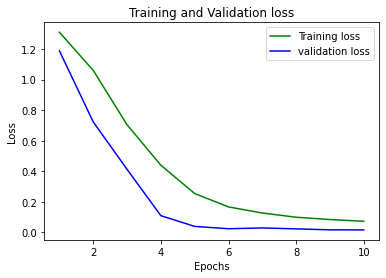

In [ ]:
import matplotlib.pyplot as plt

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, EPOCHS+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#**Test Dataset Result** ✅

---



In [ ]:
results = model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

2560/2560 [==============================] - 21s 8ms/step - loss: 0.0159
test loss, test acc: 0.015931865200400352
